<a href="https://colab.research.google.com/github/Git-Hub-Pro/Kalmanfilter/blob/master/radar_ekf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

np.random.seed(0)

EKF 알고리즘의 전체 과정은 선형 칼만 필터 알고리즘과 같습니다. 각 단계별 계산식은 약간 다른데, 크게 두 가지 차이점이 있습니다. 먼저 EKF는 선형 모델식
A와 H자리에 비선형 시스템 모델식을 사용합니다. 두 번째로 EKF는 비선형 모델의
야코비안으로 행렬 A와 H를 구한다는 점입니다. 이때 야코비안 행렬은 직전 추정값을 기준으로 계산합니다.
초깃값의 오차가 크면 이 값으로 구한 선형 모델과 실제 시스템의 차이가 많이 나게 됩니다. 그런데 시스템 모델의 오차는 EKF의 추정값 오차를 키우고, 다시 이 추정값으로 계산한 시스템 모델의 오차는 더 커집니다. 이런식으로 반복되다 보면
결국 알고리즘이 발산하게 됩니다.

In [0]:
def get_radar(xpos_pred):
    """ Return Predicted Horizontal Distance and Measured Distance by Radar."""
    xvel_w = np.random.normal(0,5)     # xvel_w : system noise of horizontal velocity [m/s]
    xvel_true = 100 + xvel_w           # xvel_true : true horizontal velocity [m/s]

    ypos_w = np.random.normal(0,10)    # ypos_w : system noise of vertical position [m].
    ypos_true = 1000 + ypos_w          # ypos_true : true vertical position [m].

    xpos_pred = xpos_pred + xvel_true * dt      # xpos_pred : predicted horizontal distance [m].

    rpos_v = xpos_pred * np.random.normal(0,0.05) # rpos_v : measurement noise of distance from radar.
    rpos_meas = np.sqrt(xpos_pred**2 + ypos_true**2) + rpos_v # r: measured distance [m] (observable).
    return rpos_meas, xpos_pred

In [0]:
def Ajacob_at(x_esti):
    return A

def Hjacob_at(x_pred):
    H[0][0] = x_pred[0] / np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    H[0][1] = 0
    H[0][2] = x_pred[2] / np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return H

In [0]:
def fx(x_esti):
    return A @ x_esti

def hx(x_pred):
    z_pred = np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return np.array([z_pred])

In [0]:
def extended_kalman_filter(z_meas, x_esti, P):
    """Extended Kalman Filter Algorithm. """
    # (1) Prediction
    A = Ajacob_at(x_esti)
    x_pred = fx(x_esti)
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    H = Hjacob_at(x_pred)
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - hx(x_pred))

    # (4) Error Covariance.
    P  = P_pred - K @ H @ P_pred

    return x_esti, P

In [0]:
# Input Parameters.
time_end = 20
dt = 0.05

In [0]:
# Initialization for system model.
# Define matrix with rank 2 for matrix operation.
# 오일러 적분법으로 dt 시간 동안 적분한 결과입니다. 
A = np.eye(3) + dt * np.array([[0,1,0],
                               [0,0,0],
                               [0,0,0]])
H = np.zeros((1,3))

Q = np.array([[0,0,0],
             [0,0.001,0],
             [0,0,0.001]])

R = np.array([[10]])

# Initialization for estimation
x_0 = np.array([0,90,1100]) # [horizontal position, horizontal velocity, vertical position].
P_0 = 10 * np.eye(3)

In [0]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)
rpos_esti_save = np.zeros(n_samples)
xvel_esti_save = np.zeros(n_samples)
rpos_meas_save = np.zeros(n_samples)

In [0]:
xpos_pred = 0
x_esti, P = None, None
for i in range(n_samples):
    z_meas, xpos_pred = get_radar(xpos_pred)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = extended_kalman_filter(z_meas,x_esti,P)
    
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]
    rpos_esti_save[i] = np.sqrt(x_esti[0]**2 + x_esti[2]**2)
    xvel_esti_save[i] = x_esti[1]
    rpos_meas_save[i] = z_meas

Text(0, 0.5, 'Horizontal Velocity [m/s]')

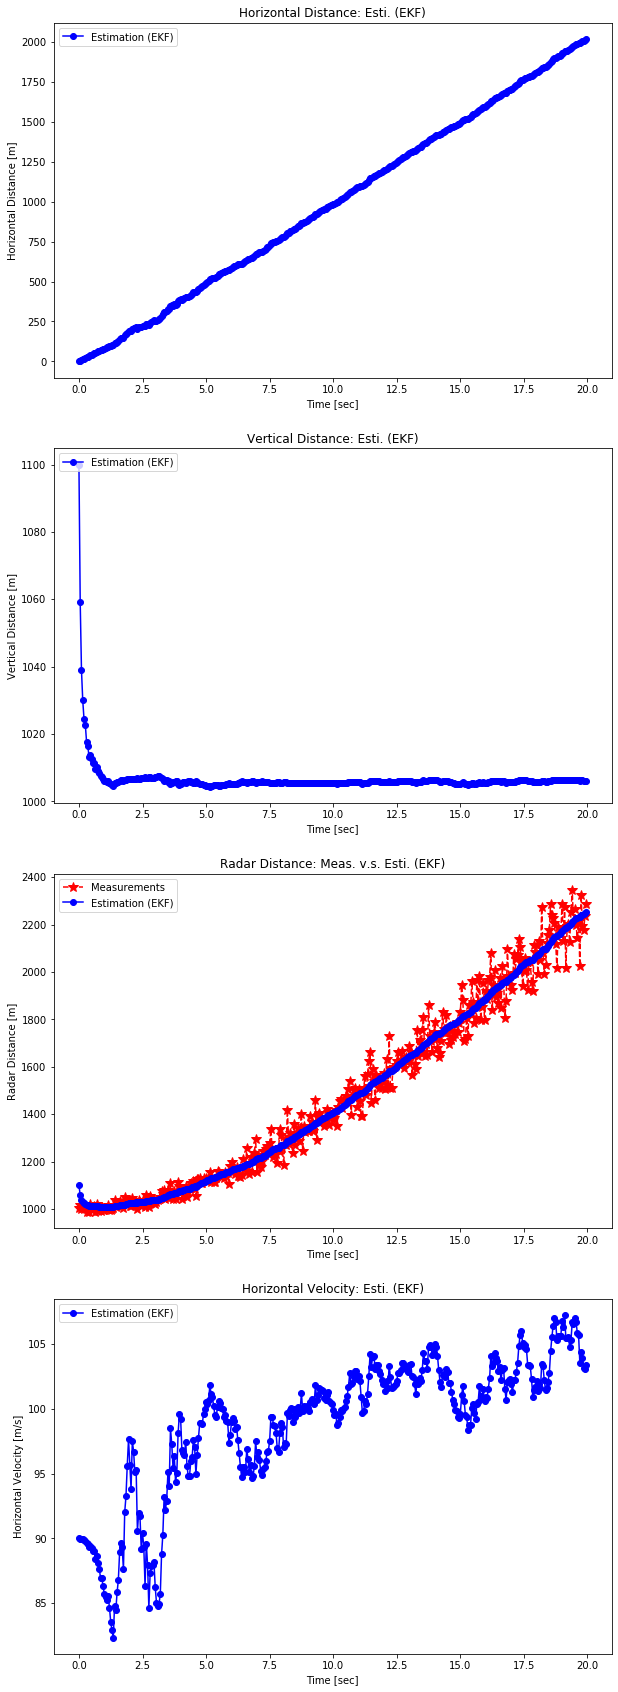

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))

plt.subplot(4, 1, 1)
plt.plot(time, xpos_esti_save, 'bo-', label='Estimation (EKF)')
plt.legend(loc='upper left')
plt.title('Horizontal Distance: Esti. (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Horizontal Distance [m]')

plt.subplot(4, 1, 2)
plt.plot(time, ypos_esti_save, 'bo-', label='Estimation (EKF)')
plt.legend(loc='upper left')
plt.title('Vertical Distance: Esti. (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Vertical Distance [m]')

plt.subplot(4, 1, 3)
plt.plot(time, rpos_meas_save, 'r*--', label='Measurements', markersize=10)
plt.plot(time, rpos_esti_save, 'bo-', label='Estimation (EKF)')
plt.legend(loc='upper left')
plt.title('Radar Distance: Meas. v.s. Esti. (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Radar Distance [m]')

plt.subplot(4, 1, 4)
plt.plot(time, xvel_esti_save, 'bo-', label='Estimation (EKF)')
plt.legend(loc='upper left')
plt.title('Horizontal Velocity: Esti. (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Horizontal Velocity [m/s]')
